# Brain Tumor Classification using CNN

## Background
Brain tumors pose a significant health challenge, where timely and precise detection is crucial for effective treatment and better patient prognosis. Magnetic Resonance Imaging (MRI) is a key tool for identifying brain abnormalities, yet manual analysis of MRI scans is labor-intensive, susceptible to errors, and demands expert knowledge. Convolutional Neural Networks (CNNs), a subset of artificial intelligence, provide a powerful means to automate and enhance the detection and classification of brain tumors, improving diagnostic speed and reliability.

## Problem Statement
This project aims to create an automated system using a CNN to detect and classify brain tumors from MRI scans into four categories: glioma, meningioma, pituitary, and no-tumor. The task involves designing a robust CNN model with TensorFlow, implemented in Google Colab, that can learn distinctive features from MRI images, manage variations in tumor presentation and image quality, and perform accurately on unseen data. The solution leverages a Kaggle dataset, requiring preprocessing and optimization to address real-world challenges like class imbalance and generalization.

## Dataset
The project utilizes the [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) from Kaggle, consisting of 7033 grayscale MRI images, split as follows:
- **Training Set**: 5712 images, organized into four class folders (glioma, meningioma, pituitary, notumor).
- **Testing Set**: 1321 images, structured similarly.
The images vary in resolution and quality, necessitating preprocessing steps such as resizing and normalization for consistent CNN input.

1. **Glioma**  
   Gliomas are tumors originating from glial cells, the supportive cells around neurons in the brain. They range from low-grade (slow-growing) to high-grade (malignant, e.g., glioblastoma) and are the most common primary brain tumors. On MRI, they often appear irregular with varying contrast, influenced by grade and surrounding edema. Accurate detection is vital due to differing treatment needs.

2. **Meningioma**  
   Meningiomas arise from the meninges, the protective layers covering the brain and spinal cord. Typically benign and slow-growing, some can become malignant or symptomatic due to pressure on brain structures. In MRI scans, they appear as well-defined, round masses with uniform contrast enhancement, aiding their identification for surgical or monitoring decisions.

3. **Pituitary**  
   Pituitary tumors develop in the pituitary gland, which regulates hormones. Usually benign (e.g., pituitary adenomas), they can disrupt hormonal balance or affect vision by pressing on optic nerves. On MRI, they are located near the sella turcica and show distinct enhancement, making classification key for managing endocrine symptoms.

4. **No-tumor**  
   This category includes MRI scans with no tumor or abnormal growth, serving as the control group. These images depict normal brain anatomy or minor non-tumor conditions (e.g., cysts). They lack the irregular masses or distortions seen in tumor cases, ensuring the CNN can differentiate healthy from pathological scans effectively.

Each category’s unique visual traits—shape, texture, intensity, and location—challenge the CNN to generalize across diverse tumor presentations and image qualities, enhancing its diagnostic potential.

## Goals
1. Develop and train a CNN model to classify MRI images into the four categories with high accuracy.
2. Mitigate issues like class imbalance, overfitting, and image variability using techniques such as data augmentation and model tuning.
3. Assess model performance with metrics including accuracy, precision, recall, and loss on the 1321-image test set.

## Significance
This system has the potential to support radiologists by offering a rapid, dependable second opinion, reducing diagnostic effort, and aiding early tumor detection. Beyond its immediate application, the project demonstrates the viability of deep learning in medical imaging, paving the way for future expansions to other diagnostic tasks or imaging types.

# Importing Libraries

In [1]:
!pip install visualkeras
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 22.1 MB/s eta 0:00:00


In [2]:
# Basics
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

# Data Processing
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Model Training
from tensorflow.keras import layers, models, Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Model Visualization
from visualkeras import layered_view
from tensorflow.keras.utils import plot_model

# Loading Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/Colab Notebooks'
train_path = os.path.join(base_path, 'Training')
test_path = os.path.join(base_path, 'Testing')
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

In [5]:
img_size = (224, 224)
batch_size = 32

# Load training and testing datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,  # 15% of data will be used for validation
    subset="training",
    seed=42,
    shuffle=True  # Required for proper splitting
)

# Load validation dataset separately
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,  # Same split ratio
    subset="validation",
    seed=42,  # Same seed to ensure correct splitting
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # No need to shuffle test data
)

class_names = train_ds.class_names
print("Class Names:", class_names)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Data Visualization

In [6]:
def plot_sample_images():
  class_samples = {class_name: [] for class_name in class_names}

  for images, labels in train_ds.unbatch():
    label = labels.numpy()
    class_name = class_names[label]

    if len(class_samples[class_name]) < 3:
        class_samples[class_name].append(images.numpy().astype("uint8"))

    if all(len(imgs) == 3 for imgs in class_samples.values()):
        break

  plt.figure(figsize=(12, 9))
  for col_idx, (class_name, images) in enumerate(class_samples.items()):
    for row_idx in range(3):
        ax = plt.subplot(3, 4, row_idx * 4 + col_idx + 1)
        plt.imshow(images[row_idx])
        if row_idx == 0:
            plt.title(class_name, fontsize=12)
        plt.axis("off")

  plt.tight_layout()
  plt.show()

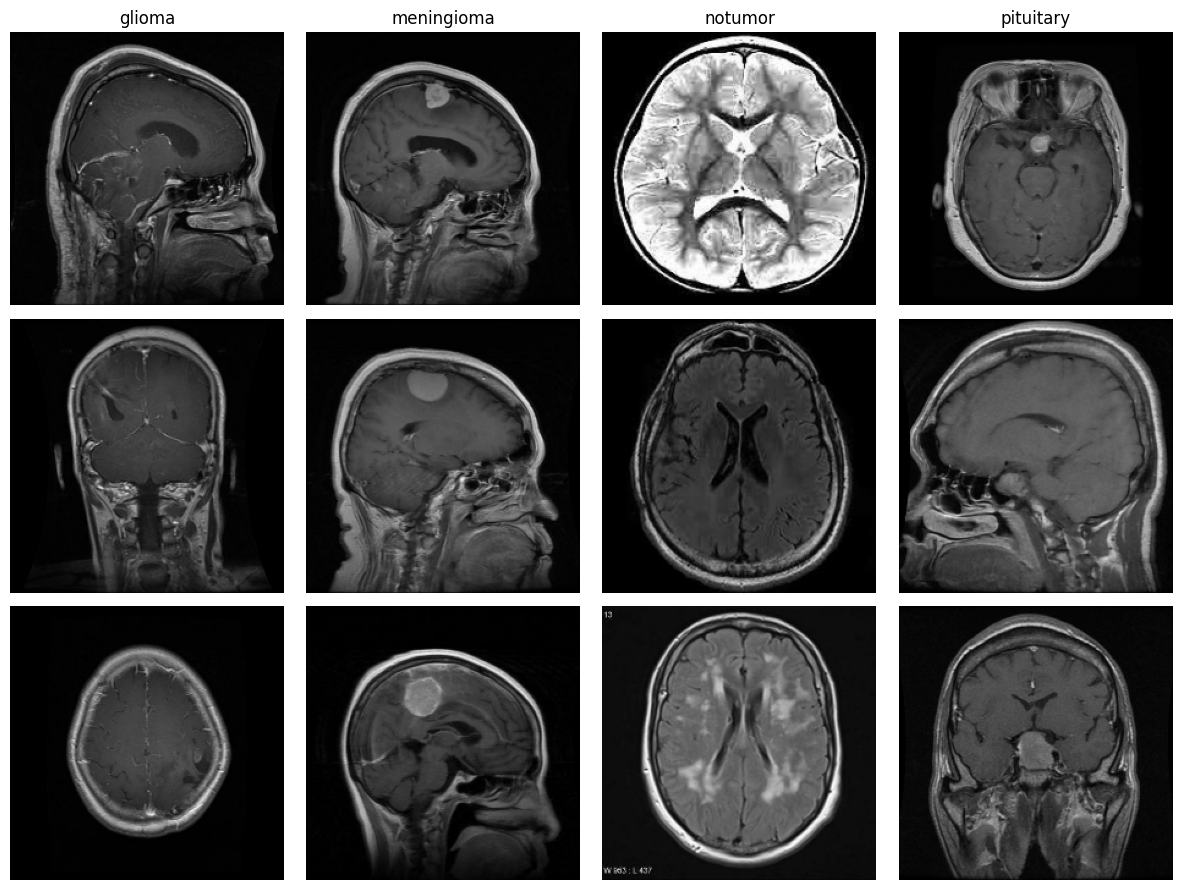

In [7]:
plot_sample_images()



As you see, each image represents a different **MRI scan of the brain**, and the dataset includes scans taken from **three different angles** to provide a comprehensive view of the brain structure.  

### MRI Scan Angles  

The images in each class are captured from **three distinct perspectives**:  

1. **Axial View** – A horizontal cross-section of the brain (top-down view).  
2. **Coronal View** – A vertical section that shows the brain from the front.  
3. **Sagittal View** – A side view, dividing the brain into left and right halves.  

These multiple angles help improve the model's ability to recognize tumor locations and structures accurately.  


Each class contains images from all three views, ensuring a diverse dataset for training a robust deep learning model.  


By leveraging these **three MRI perspectives**, the model can learn more detailed spatial features of brain tumors, leading to improved classification accuracy.

### Class Distributions

In [8]:
def count_class_distribution(dataset, class_names):
    all_labels = dataset.map(lambda x, y: y)
    all_labels = tf.concat(list(all_labels), axis=0)
    class_counts = Counter(all_labels.numpy())
    return {class_names[i]: count for i, count in class_counts.items()}

# Get class distribution for each dataset
train_class_counts = count_class_distribution(train_ds, class_names)
val_class_counts = count_class_distribution(val_ds, class_names)
test_class_counts = count_class_distribution(test_ds, class_names)

# Convert class counts to DataFrames for easier plotting
train_df = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
val_df = pd.DataFrame(list(val_class_counts.items()), columns=['Class', 'Count'])
test_df = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Count'])

# Print distributions
print("Training Class Distribution:")
print(train_df)
print("\nValidation Class Distribution:")
print(val_df)
print("\nTesting Class Distribution:")
print(test_df)

Training Class Distribution:
        Class  Count
0   pituitary   1224
1      glioma   1142
2     notumor   1336
3  meningioma   1154

Validation Class Distribution:
        Class  Count
0     notumor    259
1      glioma    179
2  meningioma    185
3   pituitary    233

Testing Class Distribution:
        Class  Count
0      glioma    300
1  meningioma    306
2     notumor    405
3   pituitary    300


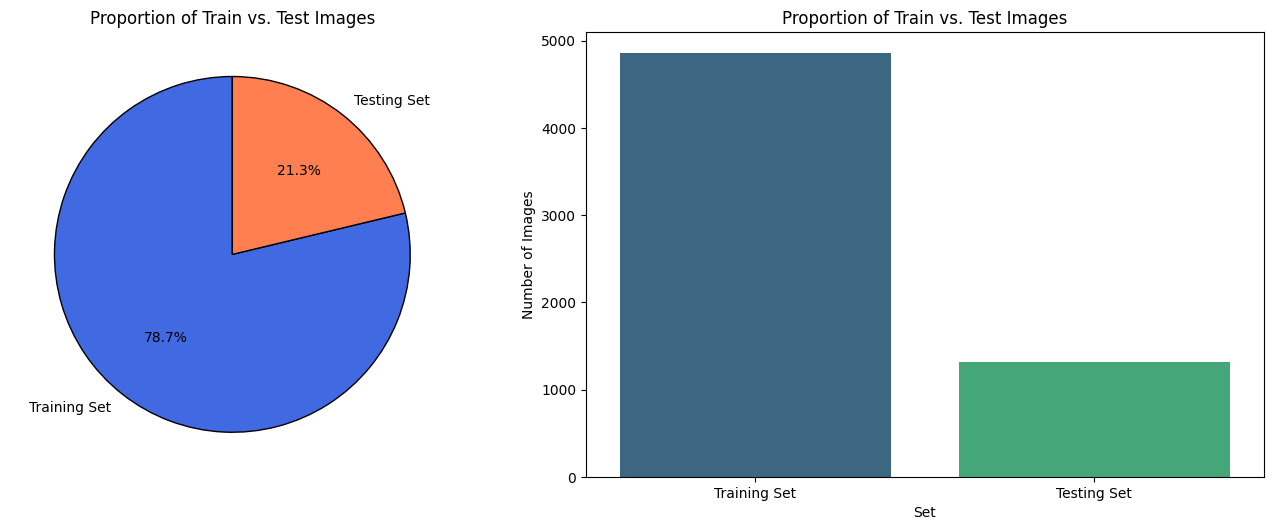

In [9]:
data = {
    'Set': ['Training Set', 'Testing Set'],
    'Count': [sum(train_class_counts.values()), sum(test_class_counts.values())],
}

df = pd.DataFrame(data)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sizes = [sum(train_class_counts.values()), sum(test_class_counts.values())]
labels = ["Training Set", "Testing Set"]
colors = ["royalblue", "coral"]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Proportion of Train vs. Test Images")

plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Set', y='Count', hue='Set', palette='viridis')

plt.title("Proportion of Train vs. Test Images")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()

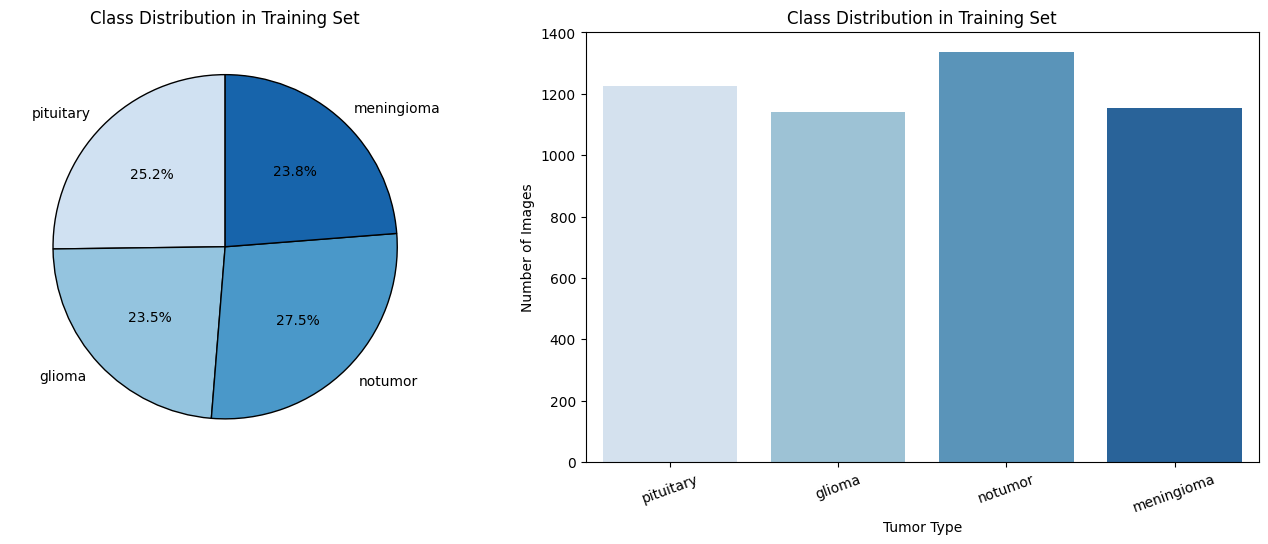

In [10]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sizes = list(train_class_counts.values())
labels = list(train_class_counts.keys())
colors = sns.color_palette("Blues", len(sizes))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution in Training Set")

plt.subplot(2, 2, 2)
sns.barplot(x="Class", y="Count", data=train_df, palette="Blues", hue="Class", dodge=False)
plt.title("Class Distribution in Training Set")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

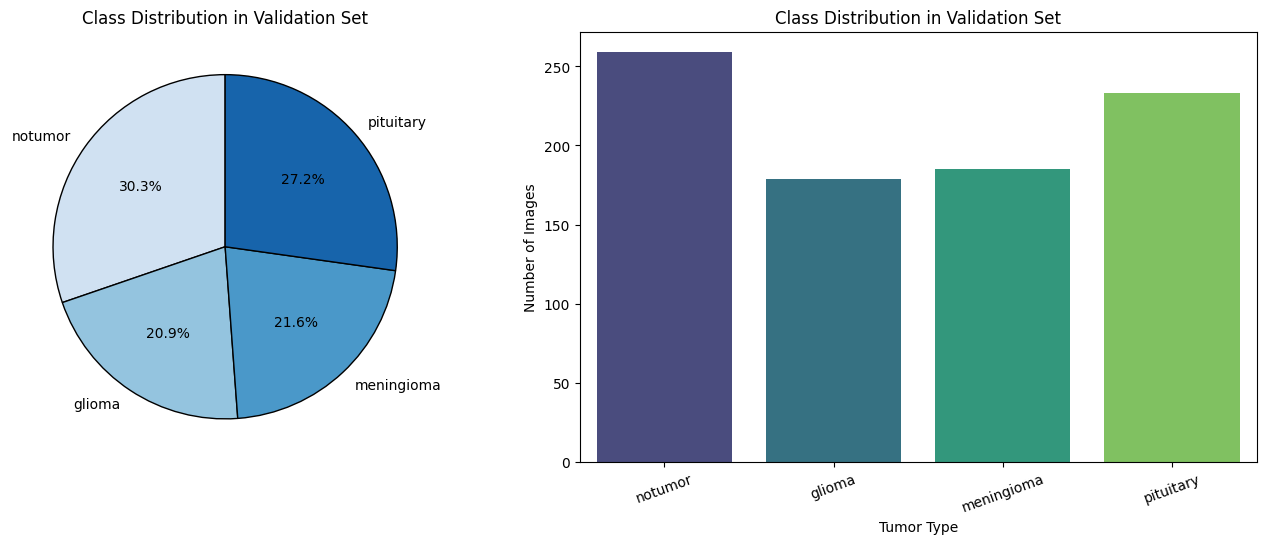

In [11]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sizes = list(val_class_counts.values())
labels = list(val_class_counts.keys())
colors = sns.color_palette("Blues", len(sizes))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution in Validation Set")

plt.subplot(2, 2, 2)
sns.barplot(x="Class", y="Count", data=val_df, palette="viridis", hue="Class", dodge=False)
plt.title("Class Distribution in Validation Set")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

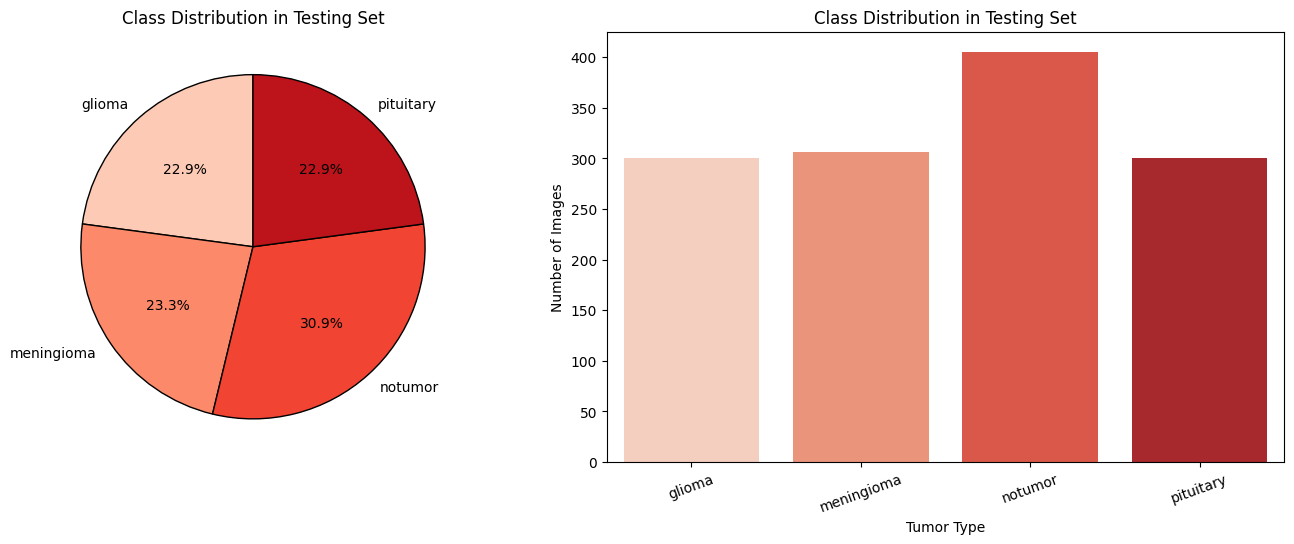

In [12]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sizes = list(test_class_counts.values())
labels = list(test_class_counts.keys())
colors = sns.color_palette("Reds", len(sizes))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution in Testing Set")

plt.subplot(2, 2, 2)
sns.barplot(x="Class", y="Count", data=test_df, palette="Reds", hue="Class", dodge=False)
plt.title("Class Distribution in Testing Set")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

The class distribution in the training, validation and testing sets is relatively balanced, with no class being overrepresented or underrepresented to a significant degree. This is a good distribution, which will help ensure that the model doesn't develop any bias towards certain classes and can learn equally from all tumor types. A balanced dataset is crucial for the model's generalization performance, and this setup provides a solid foundation for training.

## Data Augmentation

In [13]:
# Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, fill_mode="nearest"),
    layers.RandomZoom(0.1, fill_mode="nearest"),
    layers.RandomBrightness(0.15),
    layers.RandomShear(0.1, fill_mode="nearest")
])

# Apply augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Data augmentation is crucial for improving the generalization of deep learning models, especially in medical imaging where obtaining large datasets is challenging. It artificially increases the dataset size by applying transformations to existing images, reducing overfitting and improving robustness.

### **On-the-Fly Augmentation**
We use **on-the-fly augmentation**, meaning images are transformed dynamically during training rather than being stored as new images. This approach:
- **Saves storage space** since augmented images are not physically saved.
- **Provides variety in training** since each epoch sees different augmented images.
- **Improves generalization** by making the model robust to variations.

### **Applied Transformations**
- **Random Flip (Horizontal):** Helps the model learn from mirrored images, beneficial for asymmetrical structures.
- **Random Rotation (±10% of 360°):** Rotates images up to ±36° to account for slight variations in scanning angles.
- **Random Zoom (5%):** Simulates different levels of magnification to make the model invariant to slight scale changes.
- **Random Brightness (±10%):** Mimics variations in image contrast and lighting conditions.
- **Random Shear (5%):** Distorts the image slightly, helping the model become robust to slight misalignments.
- **Fill Mode ("nearest"):** Prevents unwanted black regions by filling missing pixels with the closest available pixel value.
- **No Vertical Flip:** Since brain scans are not vertically symmetrical, flipping them would create unrealistic images.


Since brain MRI images have a **black background**, certain transformations (like rotation and shear) can introduce **gray artifacts** at the edges. To fix this:
- We use **"nearest"** fill mode to extend the closest pixel values instead of introducing artificial gray areas.

By using these augmentation techniques, we improve the model's ability to classify brain tumors from different angles while maintaining medical accuracy.


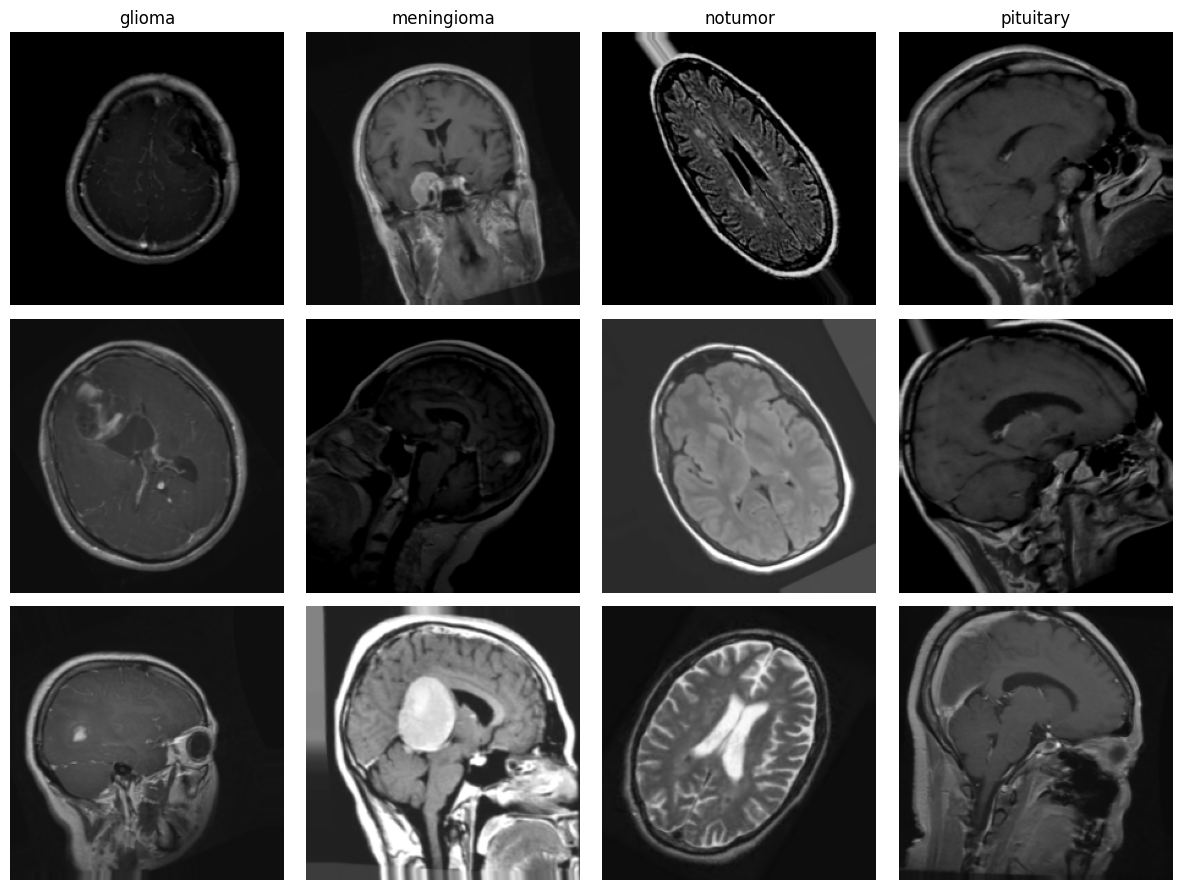

In [14]:
plot_sample_images()

# Evaluation Metrics

In medical projects, it's crucial to choose the right evaluation metrics to ensure patient safety and accurate diagnoses.


### **Precision vs Recall**
- **Precision** measures the proportion of true positives among the predicted positives. It is important when the cost of false positives is high, such as unnecessary treatments or tests.
- **Recall** measures the proportion of actual positive cases identified by the model. In medical applications, **recall** is typically more important because missing a true positive (e.g., failing to identify a patient with a disease) can have serious consequences.

### Why Recall Alone Isn’t Enough:
While **recall** is crucial for ensuring that no positive cases are missed, **recall alone is not enough**. A model with high recall might identify many positive cases, but if it also predicts many false positives, it could overwhelm healthcare providers with unnecessary treatments or tests. **Precision** helps mitigate this risk by ensuring that the predicted positive cases are actually correct.


### **F1 Score**
The **F1 score** balances **precision** and **recall**, treating both metrics equally. However, in many medical cases, it's preferable to prioritize **recall** over **precision**.

### **F2 Score**
The **F2 score** is a variant of the F1 score, where we give **recall** more weight. The **beta** parameter in the F2 score allows us to adjust the importance of recall relative to precision. For medical projects, we often want to prioritize **recall** to minimize the risk of missing critical disease cases.


### Why F2 Score is Important for Medical Projects:
In medical diagnostics, the goal is to identify as many true positives (diseased patients) as possible. **Recall** is critical in ensuring no patients are missed. However, **precision** should not be ignored, as excessive false positives could lead to unnecessary treatments or tests. The **F2 score** provides a balanced way to prioritize **recall** while still accounting for **precision**.

So:
- **Accuracy**: Not always reliable in imbalanced datasets.
- **Precision**: Useful when false positives are costly, but typically less important than recall in medical tasks.
- **Recall**: Vital to minimize false negatives in medical diagnostics.
- **F1 Score**: Balances precision and recall, but doesn't prioritize recall enough for critical medical tasks.
- **F2 Score**: Ideal for medical tasks where **recall** is prioritized, but **precision** is also considered. It ensures critical disease cases are detected while minimizing false positives.


# Model Training

## Convolutional Neural Network (CNN) Model Architecture
Convolutional Neural Network (CNN) model designed for efficient multi-class classification, built with TensorFlow/Keras, and optimized with modern training techniques.

---

### Model Definition
The CNN follows a sequential design with multiple convolutional and pooling layers, culminating in dense layers for classification. It’s crafted to balance depth and efficiency while targeting a four-class output.

---

###Inspiration from VGG Architecture
The architecture draws from the VGG philosophy, emphasizing small 3x3 convolutional kernels. These small kernels enhance non-linearity through stacked layers and reduce the number of parameters compared to larger kernels, making the model both powerful and computationally efficient.

---

### Compilation and Optimization
The model uses the Adam optimizer and sparse categorical crossentropy loss, tailored for multi-class tasks, while tracking accuracy as the primary metric.

---

### Training Callbacks
Three key callbacks enhance the training process:

- **Early Stopping**
This stops training if validation accuracy doesn’t improve for 10 epochs, reverting to the best weights to prevent overfitting.

- **Model Checkpoint**
The best model, based on validation accuracy, is automatically saved, ensuring the optimal version is preserved.

- **Learning Rate Scheduling**
The learning rate adjusts dynamically, halving when validation loss stalls for 5 epochs, down to a minimum threshold. This eliminates the need to predefine epoch counts—training can run for a large number of epochs and stop naturally when performance peaks.

---

### Model Summary
A summary of the model provides insights into its structure, layer count, and parameter totals, aiding in design verification.

---

### Design Iterations and Performance
Numerous architectures were tested, including **batch normalization**, 1x1 kernels inspired by **Google’s Inception**, large kernels from **MobileNet**, and separable convolutions. After experimentation, this design—with its focus on small kernels and dropout regularization—proved superior in accuracy and stability.

---

### Solving Validation Loss Fluctuations
Validation loss fluctuations posed a challenge during training. This was resolved by dynamically adjusting the learning rate based on validation loss, ensuring smoother convergence and robust performance.

In [15]:
# Define CNN Model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])

# Define the Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Model Checkpoint Callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Reduce learning rate when a metric has stopped improving
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001
)

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,680,580 (36.93 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

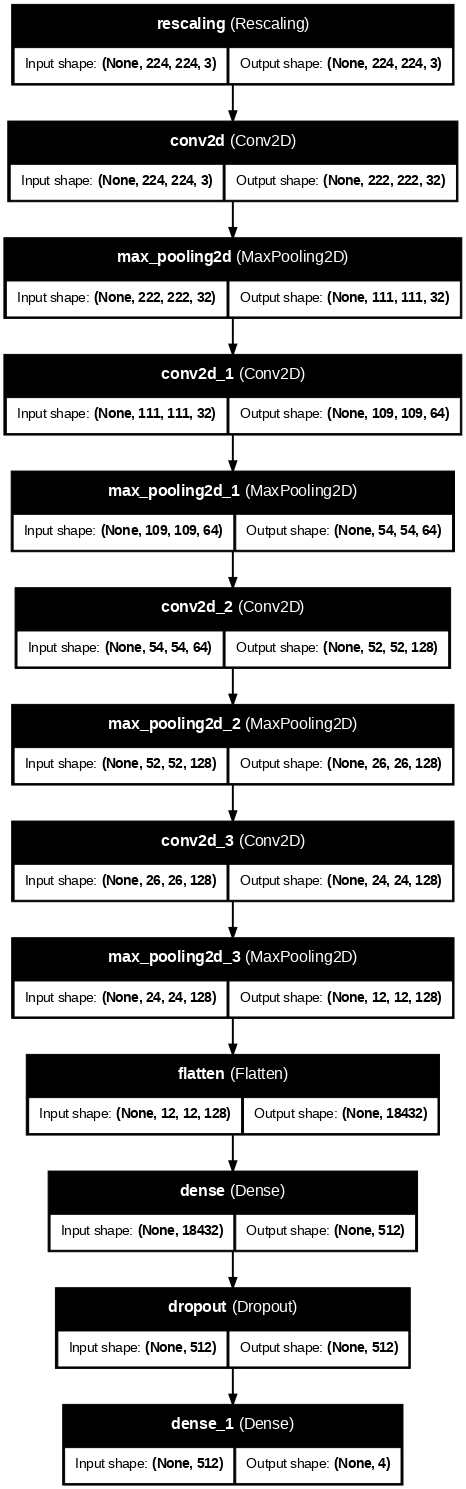

In [16]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=70)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


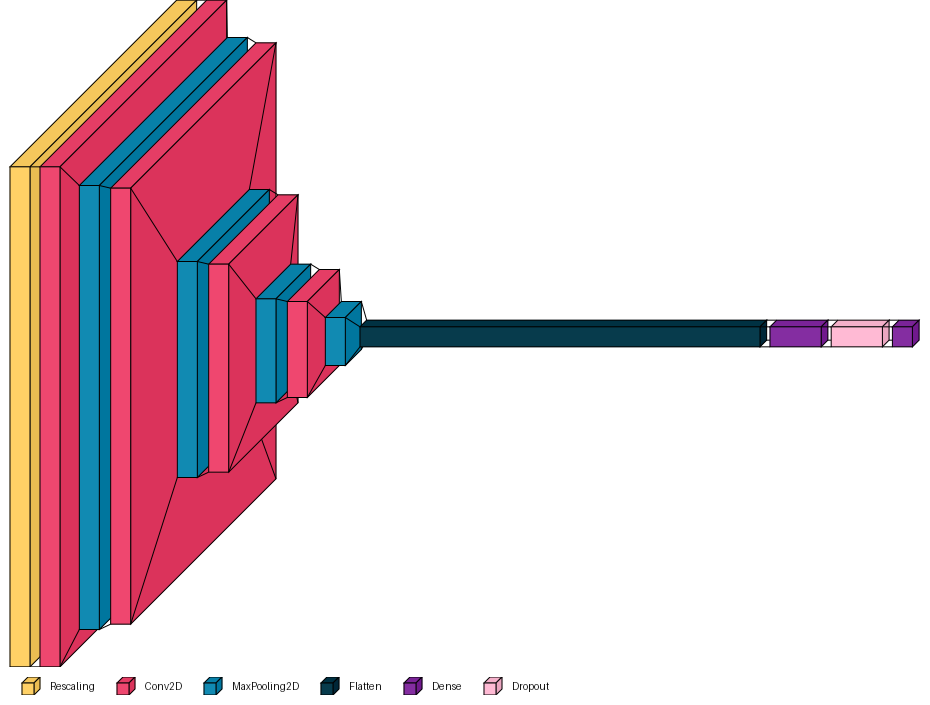

In [17]:
layered_view(model, to_file='model_visualkeras.png', legend=True, max_xy=500)

In [18]:
history = model.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping, lr_schedule],
    verbose=1
)

Epoch 1/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 98s 582ms/step - accuracy: 0.5065 - loss: 1.0774 - val_accuracy: 0.6998 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 2/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 128s 539ms/step - accuracy: 0.6965 - loss: 0.7327 - val_accuracy: 0.7278 - val_loss: 0.7008 - learning_rate: 0.0010
Epoch 3/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 144s 548ms/step - accuracy: 0.7425 - loss: 0.6238 - val_accuracy: 0.7757 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 4/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 140s 536ms/step - accuracy: 0.7927 - loss: 0.5284 - val_accuracy: 0.6157 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 5/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 530ms/step - accuracy: 0.7967 - loss: 0.5219 - val_accuracy: 0.8283 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 6/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 549ms/step - accuracy: 0.8385 - loss: 0.4505 - val_accuracy: 0.8621 - val_loss: 0.3793 - learning_rate: 0.0010
Epoch 7/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 530ms/step - accuracy: 

In [19]:
!cp best_model.keras /content/drive/MyDrive/Colab\ Notebooks/models/

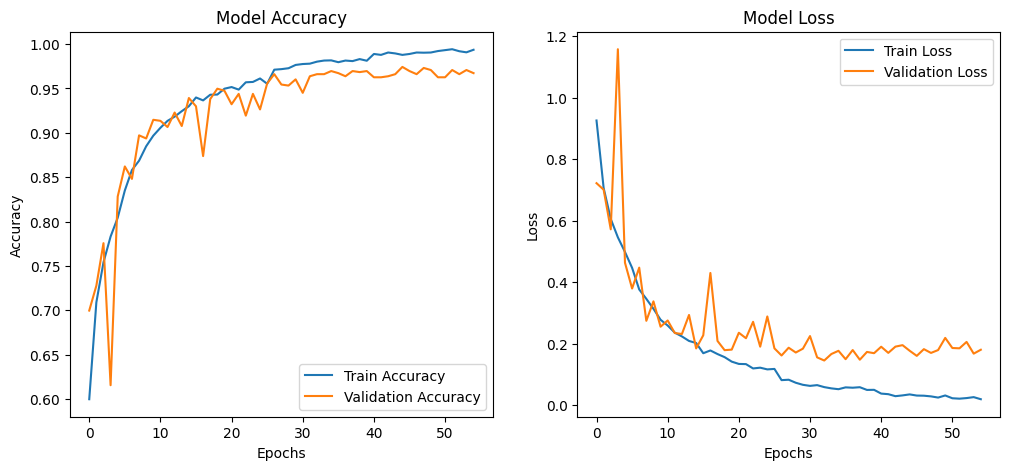

In [20]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

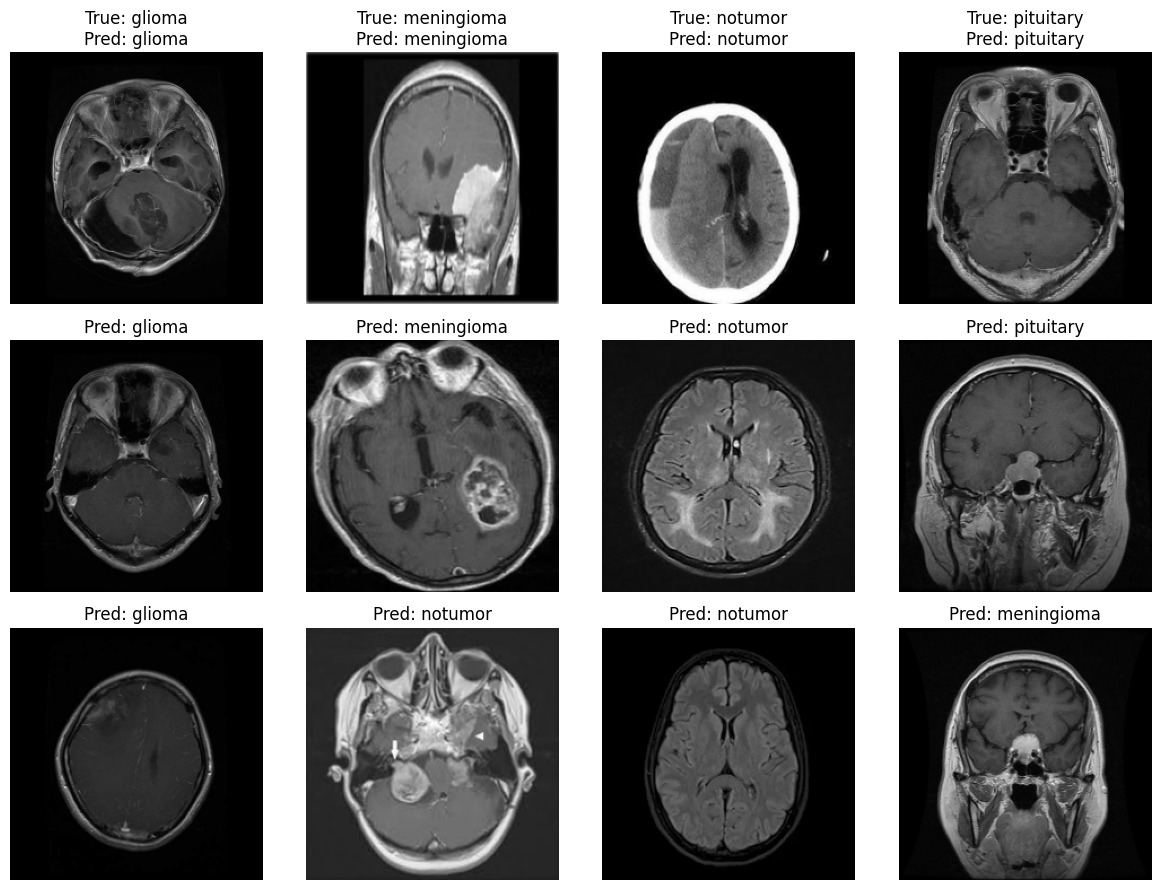

In [27]:
import contextlib

def plot_predicted_images():
    class_samples = {class_name: [] for class_name in class_names}

    for images, labels in test_ds.unbatch():
        image = images.numpy().astype("uint8")
        label = labels.numpy()
        class_name = class_names[label]

        with contextlib.redirect_stdout(open(os.devnull, 'w')):
            prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_label = np.argmax(prediction, axis=1)[0]
        predicted_class_name = class_names[predicted_label]

        if len(class_samples[class_name]) < 3:
            class_samples[class_name].append((image, predicted_class_name))

        if all(len(imgs) == 3 for imgs in class_samples.values()):
            break

    plt.figure(figsize=(12, 9))
    for col_idx, (class_name, samples) in enumerate(class_samples.items()):
        for row_idx in range(3):
            image, predicted_class_name = samples[row_idx]
            ax = plt.subplot(3, 4, row_idx * 4 + col_idx + 1)
            plt.imshow(image)
            if row_idx == 0:
                plt.title(f"True: {class_name}\nPred: {predicted_class_name}", fontsize=12)
            else:
                plt.title(f"Pred: {predicted_class_name}", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()


plot_predicted_images()

In [29]:
y_true = tf.concat([y for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

test_accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=4, target_names=test_ds.class_names, output_dict=True)

# Extract metrics
precision = report["weighted avg"]["precision"]
recall = report["weighted avg"]["recall"]
f1_score = report["weighted avg"]["f1-score"]

# Compute F2-score using beta=2 formula
beta = 2
f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score (Beta=2): {f2_score:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
Test Accuracy: 0.9817
Precision: 0.9817
Recall: 0.9817
F1 Score: 0.9817
F2 Score (Beta=2): 0.9817


<Figure size 1000x800 with 0 Axes>

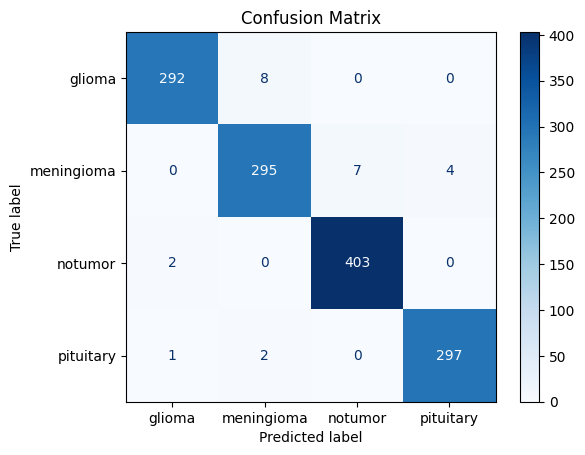

In [30]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=test_ds.class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [31]:
class_metrics = {}
for class_name in class_names:
    class_metrics[class_name] = {
        "precision": report[class_name]["precision"],
        "recall": report[class_name]["recall"],
        "f1_score": report[class_name]["f1-score"],
        "accuracy": report[class_name]["accuracy"] if "accuracy" in report[class_name] else None
    }


# Print the class-specific metrics
for class_name, metrics in class_metrics.items():
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    if metrics['accuracy'] is not None:
        print(f"Accuracy: {metrics['accuracy']:.4f}")


Class: glioma
Precision: 0.9898
Recall: 0.9733
F1 Score: 0.9815

Class: meningioma
Precision: 0.9672
Recall: 0.9641
F1 Score: 0.9656

Class: notumor
Precision: 0.9829
Recall: 0.9951
F1 Score: 0.9890

Class: pituitary
Precision: 0.9867
Recall: 0.9900
F1 Score: 0.9884


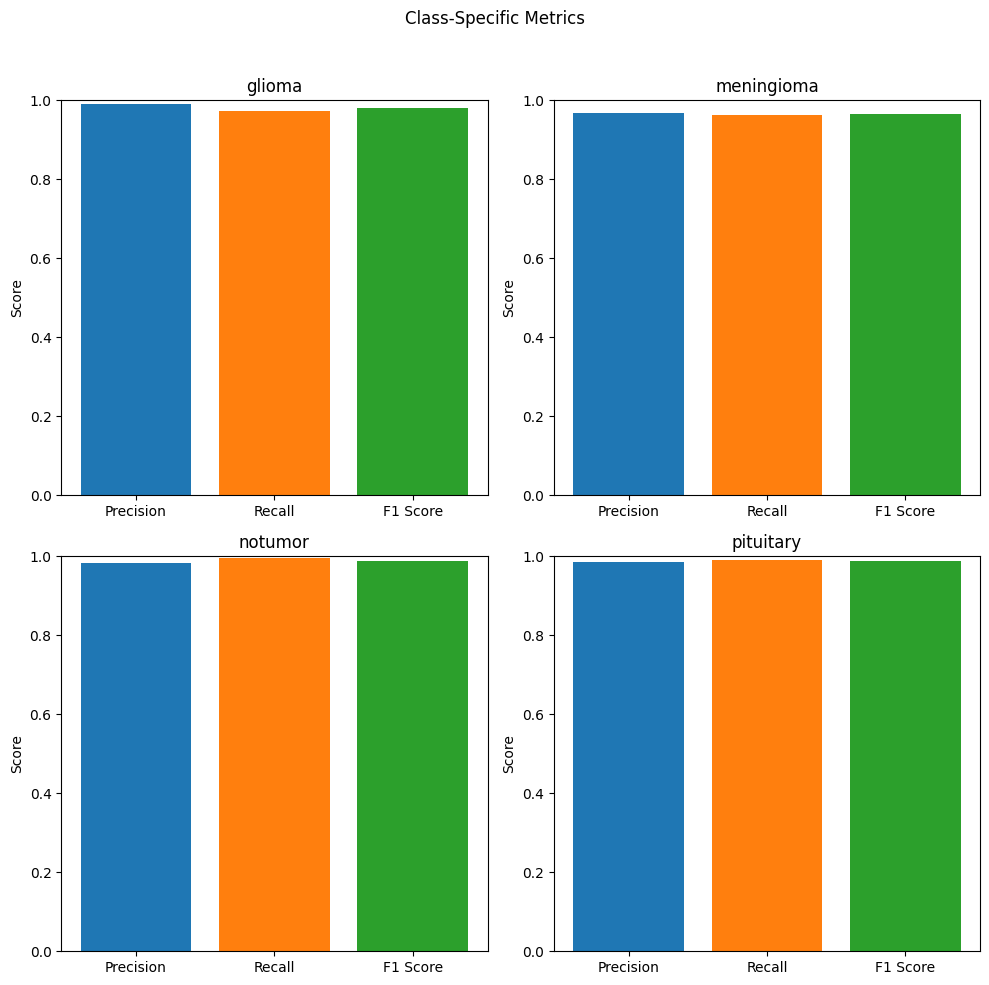

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Class-Specific Metrics')

for idx, (class_name, metrics) in enumerate(class_metrics.items()):
    row, col = divmod(idx, 2)
    ax = axs[row, col]
    metric_names = ["Precision", "Recall", "F1 Score"]
    metric_values = [metrics["precision"], metrics["recall"], metrics["f1_score"]]

    if metrics["accuracy"] is not None:
        metric_names.append("Accuracy")
        metric_values.append(metrics["accuracy"])

    ax.bar(metric_names, metric_values, color=['C0', 'C1', 'C2'])
    ax.set_ylim(0, 1)
    ax.set_title(class_name)
    ax.set_ylabel('Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#Brain Tumor Classifier Report

##Model Performance

The model shows strong generalization on the test set, with high scores across key metrics:

-**Test Accuracy:** 98.17% of test samples are correctly classified.

-**Precision:** 98.17% of positive predictions are correct on average.

-**Recall:** 98.17% of true positive instances are identified.

-**F1 Score:** The harmonic mean of precision and recall is 98.17%.

-**F2 Score:** With a beta of 2, prioritizing recall, the score is 98.17%.

For this medical project, the F2 score is the most critical metric, as it places greater weight on recall—ensuring fewer cases are missed—while still considering precision. The robust F2 score of 98.17% underscores the model’s reliability in a healthcare context where false negatives could have serious consequences.

##Class-wise Performance

The model performs admirably across all classes, aligning with the medical priority of minimizing missed diagnoses.

-**Glioma:** Precision: 98.98%, Recall: 97.33%, F1 Score: 98.15%

-**Meningioma:** Precision: 96.72%, Recall: 96.41%, F1 Score: 96.56%

-**Notumor:** Precision: 98.29%, Recall: 99.51%, F1 Score: 98.90%

-**Pituitary:** Precision: 98.67%, Recall: 99.00%, F1 Score: 98.84%

The high recall for pituitary (99.00%) and near-perfect recall for notumor (99.51%) are particularly notable, while glioma and meningioma maintain strong recall above 96%. Combined with an overall F2 score of 98.17%, these results confirm the model’s suitability for medical applications, where detecting true cases outweighs the cost of occasional false positives. The architecture and training strategies have clearly delivered a solution tailored to this critical need.

# Conclusion
The brain tumor classifier, developed as a Convolutional Neural Network (CNN) using TensorFlow/Keras, stands as a highly effective tool for classifying brain tumors into four categories: glioma, meningioma, notumor, and pituitary. Inspired by the VGG architecture’s use of small 3x3 kernels, the model leverages depth and efficiency while incorporating on-the-fly data augmentation to enhance robustness. This technique, applying real-time transformations like rotations and flips during training, enriched the dataset and improved generalization without requiring additional storage. Combined with advanced training strategies—early stopping, model checkpointing, and dynamic learning rate scheduling—the model achieved optimal convergence and resolved issues like validation loss fluctuations.

Iterative testing of alternative architectures—including batch normalization, 1x1 kernels from Inception, large kernels from MobileNet, and separable convolutions—confirmed that the chosen design, enhanced by small kernels, dropout regularization, and data augmentation, outperformed other approaches. This careful refinement, paired with on-the-fly augmentation and strategic callbacks, tailored the classifier to the demands of brain tumor diagnosis. Ultimately, the brain tumor classifier delivers a powerful, dependable solution for early detection, poised to support improved patient outcomes in clinical settings.